In [1]:
import os
import librosa
import numpy as np

dataset_base_path = "./water pump audio for anomaly detection/" 
train_normal_path = os.path.join(dataset_base_path, "train-normal")
test_normal_path = os.path.join(dataset_base_path, "test-normal")
anomaly_path = os.path.join(dataset_base_path, "anomaly")

def load_audio_files(path, sr=22050, duration=10):
    audio_files = []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            file_path = os.path.join(path, file)
            audio, _ = librosa.load(file_path, sr=sr, duration=duration)
            audio_files.append(audio)
    return np.array(audio_files)

train_normal_files = load_audio_files(train_normal_path)
test_normal_files = load_audio_files(test_normal_path)
anomaly_files = load_audio_files(anomaly_path)

In [2]:
print(train_normal_files.shape)
print(test_normal_files.shape)
print(anomaly_files.shape)

(2241, 220500)
(400, 220500)
(456, 220500)


In [3]:
def split_audio_files(audio_files, segment_length=5, sr=22050, overlap=0.5):
    return audio_files
    segment_duration = 5  # seconds
    hop = 2.5  # seconds
    segment_samples = int(segment_duration * sr)
    hop_samples = int(hop * sr)

    segments = []
    for audio in audio_files:
        if len(audio) >= sr * 10:  # Ensure the audio is at least 10 seconds
            # 0-5 seconds
            segment1 = audio[0:segment_samples]
            # 2.5-7.5 seconds
            segment2 = audio[hop_samples:hop_samples + segment_samples]
            # 5-10 seconds
            segment3 = audio[2 * hop_samples:2 * hop_samples + segment_samples]

            segments.extend([segment1, segment2, segment3])
    return np.array(segments)

In [4]:
train_normal_files_augmented = split_audio_files(train_normal_files)
test_normal_files_augmented = split_audio_files(test_normal_files)
anomaly_files_augmented = split_audio_files(anomaly_files)

In [5]:
print(train_normal_files_augmented.shape)
print(test_normal_files_augmented.shape)
print(anomaly_files_augmented.shape)

(2241, 220500)
(400, 220500)
(456, 220500)


In [6]:
# test from here
def extract_mel_spectrograms(audio_files, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
  mel_spectrograms = []
  for audio in audio_files:
      mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
      mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
      mel_spectrograms.append(mel_spec_db)
  return np.array(mel_spectrograms)

In [7]:
train_mel_specs = extract_mel_spectrograms(train_normal_files_augmented)
test_mel_specs = extract_mel_spectrograms(test_normal_files_augmented)
anomaly_mel_specs = extract_mel_spectrograms(anomaly_files_augmented)

In [8]:
print(train_mel_specs.shape)
print(test_mel_specs.shape)
print(anomaly_mel_specs.shape)

(2241, 128, 431)
(400, 128, 431)
(456, 128, 431)


In [9]:
train_mel_specs = train_mel_specs.transpose(0, 2, 1)
test_mel_specs = test_mel_specs.transpose(0, 2, 1)
anomaly_mel_specs = anomaly_mel_specs.transpose(0, 2, 1)

In [10]:
print(train_mel_specs.shape)
print(test_mel_specs.shape)
print(anomaly_mel_specs.shape)

(2241, 431, 128)
(400, 431, 128)
(456, 431, 128)


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_mel_specs_scaled = scaler.fit_transform(train_mel_specs.reshape(-1, train_mel_specs.shape[-1])).reshape(train_mel_specs.shape)
test_mel_specs_scaled = scaler.transform(test_mel_specs.reshape(-1, test_mel_specs.shape[-1])).reshape(test_mel_specs.shape)
anomaly_mel_specs_scaled = scaler.transform(anomaly_mel_specs.reshape(-1, anomaly_mel_specs.shape[-1])).reshape(anomaly_mel_specs.shape)

In [12]:
print(train_mel_specs_scaled.shape)
print(test_mel_specs_scaled.shape)
print(anomaly_mel_specs_scaled.shape)

(2241, 431, 128)
(400, 431, 128)
(456, 431, 128)


In [13]:
import gc

gc.collect()

0

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D

def build_cnn_autoencoder(input_shape):
    """
    Build a convolutional autoencoder for 2D data.

    Args:
        input_shape (tuple): Shape of the input data (time frames, features, channels).

    Returns:
        keras.Model: Autoencoder model.
    """
    # Input layer
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Output: (216, 64, 32)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Output: (108, 32, 64)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Output: (54, 16, 128)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)  # Output: (108, 32, 128)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Output: (216, 64, 64)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Output: (432, 128, 32)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output: (432, 128, 1)

    # Cropping to match the original input size
    decoded = Cropping2D(cropping=((1, 0), (0, 0)))(x)  # Output: (431, 128, 1)

    # Model
    autoencoder = Model(input_layer, decoded)
    latent_model = Model(input_layer, encoded)
    return autoencoder, latent_model

# Input shape: (time frames, features, channels)
input_shape = (431, 128, 1)  # Add channel dimension for 2D CNN
autoencoder, latent_model = build_cnn_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 431, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 431, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 216, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 216, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 108, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 54, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 54, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 108, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 108, 32, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 216, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 216, 64, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 432, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 432, 128, 1)    │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 431, 128, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
train_mel_specs_reshaped = train_mel_specs_scaled[..., np.newaxis]
test_mel_specs_reshaped = test_mel_specs_scaled[..., np.newaxis]
anomaly_mel_specs_reshaped = anomaly_mel_specs_scaled[..., np.newaxis]

In [16]:
print(train_mel_specs_reshaped.shape)
print(test_mel_specs_reshaped.shape)
print(anomaly_mel_specs_reshaped.shape)

(2241, 431, 128, 1)
(400, 431, 128, 1)
(456, 431, 128, 1)


In [17]:
import gc

gc.collect()

13

In [18]:
autoencoder.fit(
    train_mel_specs_reshaped, train_mel_specs_reshaped,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 877ms/step - loss: 0.0259 - val_loss: 0.0059
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 848ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 3/50
 3/56 ━━━━━━━━━━━━━━━━━━━━ 51s 976ms/step - loss: 0.0046

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential, save_model
from google.colab import files

autoencoder.save('my_model.h5')
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.losses import MeanSquaredError

autoencoder = load_model("my_model.h5", custom_objects={'mse': MeanSquaredError()})

In [ ]:
# Reconstruct spectrograms
#reconstructed_train = autoencoder.predict(train_mel_specs_reshaped)
reconstructed_test = autoencoder.predict(test_mel_specs_reshaped)
reconstructed_anomaly = autoencoder.predict(anomaly_mel_specs_reshaped)

# Calculate Mean Squared Error (MSE) for reconstruction loss
#train_loss = np.mean(np.square(train_mel_specs_reshaped - reconstructed_train), axis=(1, 2, 3))
test_loss = np.mean(np.square(test_mel_specs_reshaped - reconstructed_test), axis=(1, 2, 3))
anomaly_loss = np.mean(np.square(anomaly_mel_specs_reshaped - reconstructed_anomaly), axis=(1, 2, 3))

#print(f"Mean Reconstruction Loss (Train): {np.mean(train_loss)}")
print(f"Mean Reconstruction Loss (Test): {np.mean(test_loss)}")
print(f"Mean Reconstruction Loss (Anomaly): {np.mean(anomaly_loss)}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Mean Reconstruction Loss (Test): 0.0017204985488206148
Mean Reconstruction Loss (Anomaly): 0.0017487957375124097


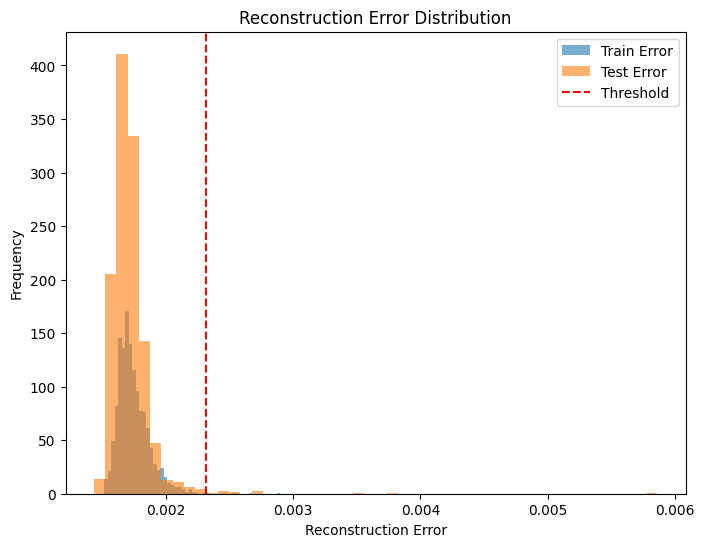

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(anomaly_loss, bins=50, alpha=0.6, label='Train Error')
plt.hist(test_loss, bins=50, alpha=0.6, label='Test Error')
plt.axvline(np.mean(test_loss) + 3 * np.std(test_loss), color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()